# Analysing Statsbomb event data for Women's 2019 FIFA World Cup
## Match: Norway (0) vs England (3)
### Date: 27 June 2019

Event data from Statsbomb open-data: https://github.com/statsbomb/open-data

### 1. Imports and read in json data to DataFrame

In [4]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib.patches import Arc, Rectangle, ConnectionPatch, Patch
from pandas.io.json import json_normalize
%matplotlib inline 

with open('./open-data/data/events/69199.json') as data_file:
    data = json.load(data_file)
df = json_normalize(data, sep = '_')

### 2. Use matplotlib patches to draw a pitch
The Statsbomb documentation provides us with details for the pitch dimensions:
https://github.com/statsbomb/open-data/blob/master/doc/StatsBomb%20Event%20Data%20Specification%20v1.0.2.pdf

In [5]:
def draw_pitch(ax, colour = None, edge = 'black'):
    
    Background = Rectangle([-10,-10], width = 135, height = 95, fill = False)
    # Pitch Outline and Centre Line
    Pitch = Rectangle([0,0], width = 120, height = 80, edgecolor = edge, fill = False)
    
    if colour:
        Background = Rectangle([-10,-10], width = 135, height = 95, color = colour)
        # Pitch Outline and Centre Line
        Pitch = Rectangle([0,0], width = 120, height = 80, edgecolor = edge, facecolor = colour)
    
    # Left, Right Penalty Area and midline
    LeftPenalty = Rectangle([0,18], width = 18, height = 44, edgecolor = edge, fill = False)
    RightPenalty = Rectangle([102,18], width = 18, height = 44, edgecolor = edge, fill = False)
    midline = ConnectionPatch([60,0], [60,80], 'data', 'data', color = edge)
    
    # Left, Right 6-yard Box
    LeftSixYard = Rectangle([0,30], width = 6, height = 20, edgecolor = edge, fill = False)
    RightSixYard = Rectangle([114,30], width = 6, height = 20, edgecolor = edge, fill = False)
    
    #Goals
    LeftGoal = Rectangle([-3,36], width = 3, height = 8, linewidth = 1, edgecolor = 'black', fill = False)
    RightGoal = Rectangle([120,36], width = 3, height = 8, linewidth = 1, edgecolor = 'black', fill = False)
    
    # Prepare Circles
    centreCircle = plt.Circle((60,40), 8.1, color = edge, fill = False)
    centreSpot = plt.Circle((60,40), 0.71, color = edge)
    
    # Penalty spots and Arcs around penalty boxes
    leftPenSpot = plt.Circle((12,40), 0.71, color = edge)
    rightPenSpot = plt.Circle((108,40), 0.71, color = edge)
    leftArc = Arc((14, 40), height = 16.2, width = 16.2, angle = 0, theta1 = 300, theta2 = 60, color = edge)
    rightArc = Arc((106, 40), height = 16.2, width = 16.2, angle = 0, theta1 = 120, theta2 = 240, color = edge)
    
    element = [Background, Pitch, LeftPenalty, RightPenalty, midline, LeftSixYard, RightSixYard, centreCircle, 
               centreSpot, rightPenSpot, leftPenSpot, leftArc, rightArc, LeftGoal, RightGoal]
    for i in element:
        ax.add_patch(i)

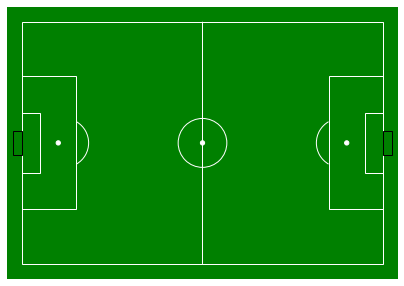

In [6]:
fig = plt.figure()
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1, 1, 1)
draw_pitch(ax, 'green', 'white')
plt.ylim(-5, 85)
plt.xlim(-5, 125)
plt.axis('off')
plt.show()

### 3. Tracking active zone with a heat map
Use seaborn to create a smoothed out scatter plot of player locations to identify player presence, with the ability to overlay passes and shots.

In [7]:
def heat_pass_shot_map(ax, data, player_name, passes = False, shots = False, heatmap = False):
    shot_data = data[(data['type_name'] == 'Shot') & (data['player_name'] == player_name)]
    pass_data = data[(data['type_name'] == 'Pass') & (data['player_name'] == player_name)]
    action_data = data[(data['player_name'] == player_name)][:-1]
    
    ax.title.set_text(player_name)

    if heatmap:
        draw_pitch(ax)
    else:
        draw_pitch(ax, 'green', 'white')
    
    if passes:
        for i in range(len(pass_data)):
            # Differentiate different half by different colour
            color = 'blue' if pass_data.iloc[i]['period'] == 1 else 'red'
            ax.annotate('', xy = (pass_data.iloc[i]['pass_end_location'][0], pass_data.iloc[i]['pass_end_location'][1]), xycoords = 'data',
                xytext = (pass_data.iloc[i]['location'][0], pass_data.iloc[i]['location'][1]), textcoords = 'data',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color=color))
    
    if shots:
        for i in range(len(shot_data)):
            # Differentiate different half by different colour
            color = 'black' 
            if shot_data.iloc[i]['shot_outcome_name'] == 'Goal':
                color ='yellow'
            elif shot_data.iloc[i]['shot_outcome_name'] == 'Saved':
                color = 'purple'
            ax.annotate('', xy = (shot_data.iloc[i]['shot_end_location'][0], shot_data.iloc[i]['shot_end_location'][1]), xycoords = 'data',
                xytext = (shot_data.iloc[i]['location'][0], shot_data.iloc[i]['location'][1]), textcoords = 'data',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color=color))
    
    if heatmap:
        x_coord = [i[0] for i in action_data['location']]
        y_coord = [i[1] for i in action_data['location']]
        sns.kdeplot(x_coord, y_coord, shade = 'True', color = 'green', n_levels = 30, ax=ax)
    

Display the heatmap and passes for Midfielder Fran Kirby and Defender Millie Bright. We can see that many of the passes originate from the darker areas of the heatmap, as would be expected. Blue arrows represent passes in the first half of the game, red arrows represent passes in the second half.

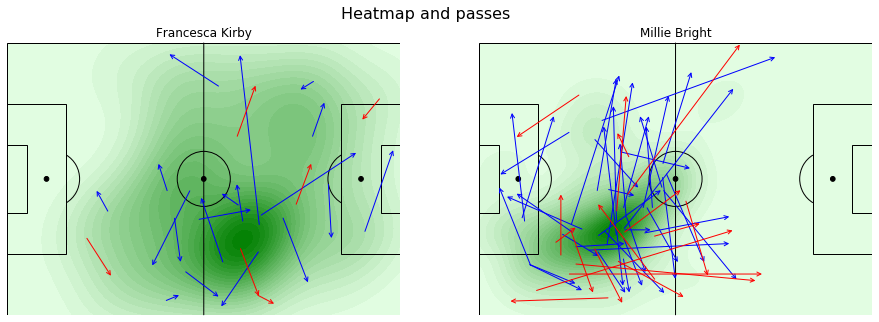

In [8]:
fig = plt.figure(edgecolor='green')
fig.set_size_inches(15.5, 5)
fig.suptitle('Heatmap and passes', fontsize=16)

ax1=fig.add_subplot(1, 2, 1)
ax2=fig.add_subplot(1, 2, 2)


heat_pass_shot_map(ax1, df, 'Francesca Kirby', passes = True, heatmap = True)
heat_pass_shot_map(ax2, df, 'Millie Bright', passes = True, heatmap = True)


ax1.set(ylim=(0, 80))
ax1.set(xlim=(0, 120))
ax1.axis('off')
ax2.set(ylim=(0, 80))
ax2.set(xlim=(0, 120))
ax2.axis('off')
plt.show()

Display shots for Isabel Herlovsen (Striker) and Lucy Bronze (Right Back). Goals are coloured Yellow, Saves are coloured Purple, and Blocks, Off Target and others are coloured Black.

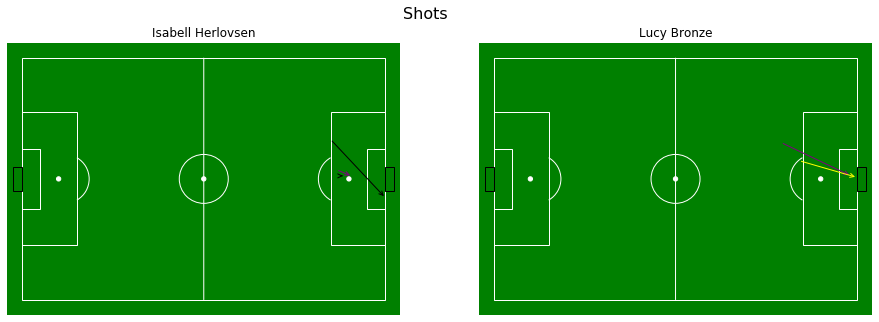

In [9]:
fig = plt.figure(edgecolor='green')
fig.set_size_inches(15.5, 5)
fig.suptitle('Shots', fontsize=16)

ax1=fig.add_subplot(1, 2, 1)
ax2=fig.add_subplot(1, 2, 2)


heat_pass_shot_map(ax1, df, 'Isabell Herlovsen', passes = False, shots = True)
heat_pass_shot_map(ax2, df, 'Lucy Bronze', passes = False, shots = True)


ax1.set(ylim=(-5, 85))
ax1.set(xlim=(-5, 125))
ax1.axis('off')
ax2.set(ylim=(-5, 85))
ax2.set(xlim=(-5, 125))
ax2.axis('off')
plt.show()

### 4. Possession and other overall stats
The Possession % metric that the majority of media outlets use is really just a pass ratio. The pass ratio approach is: team possession % = team’s total passes / both teams’ total passes.

In [10]:
def draw_horizontal_bar(ax, labels, data, colors, title):
    
    y = [0]
    start = 0
    values = []
    for i in range(0, len(data)):
        values.append((start, data[i]))
        ax.text(start + data[i]-(data[i]/2), 0.45, round(data[i]), fontsize=12, color='white')
        start = data[i]
    ax.broken_barh(values, [0.25, 0.5], facecolors=colors, edgecolor='white', linewidth=2, label=labels)
    ax.set_ylabel(title, rotation=0, labelpad=40, fontsize = 16)
    ax.set_ylim(0,1)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


In [11]:
pass_count = df[(df['type_name'] == 'Pass')].groupby(['team_name']).count()[['type_name']]
eng_pass = pass_count.iloc[0]['type_name']
nor_pass = pass_count.iloc[1]['type_name']
total_pass = eng_pass + nor_pass

eng_poss = (eng_pass / total_pass)*100
nor_poss = (nor_pass / total_pass)*100

In [12]:
shot_count = df[(df['type_name'] == 'Shot')].groupby(['team_name']).count()[['type_name']]
eng_shot = shot_count.iloc[0]['type_name']
nor_shot = shot_count.iloc[1]['type_name']

In [13]:
ontarget_data = df[(df['type_name'] == 'Shot') &
                   (df['shot_outcome_name'] != 'Off T') &
                   (df['shot_outcome_name'] != 'Blocked') & 
                   (df['shot_outcome_name'] != 'Post')].groupby(['team_name']).count()[['shot_outcome_name']]
eng_ontarget = ontarget_data.iloc[0]['shot_outcome_name']
nor_ontarget = ontarget_data.iloc[1]['shot_outcome_name']

In [14]:
corner_count = df[(df['pass_type_name'] == 'Corner')].groupby(['team_name']).count()[['pass_type_name']]
eng_corner = corner_count.iloc[0]['pass_type_name']
nor_corner = corner_count.iloc[1]['pass_type_name']

In [15]:
foul_count = df[(df['type_name'] == 'Foul Committed')].groupby(['team_name']).count()[['type_name']]
eng_foul = foul_count.iloc[0]['type_name']
nor_foul = foul_count.iloc[1]['type_name']

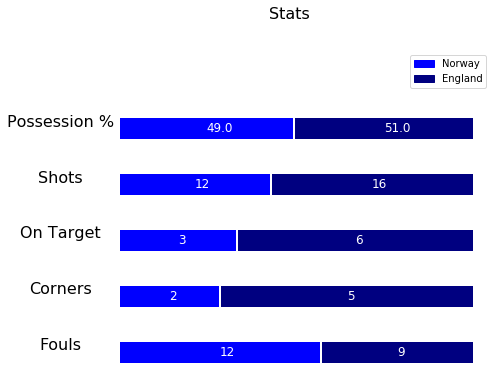

In [16]:
fig = plt.figure()
fig.set_size_inches(7, 6)
fig.suptitle('Stats', fontsize=16)
ax = fig.add_subplot(6, 1, 1)
ax1 = fig.add_subplot(6, 1, 2)
ax2 = fig.add_subplot(6, 1, 3)
ax3 = fig.add_subplot(6, 1, 4)
ax4 = fig.add_subplot(6, 1, 5)
ax5 = fig.add_subplot(6, 1, 6)

# Legend
colors = ('blue', 'navy')
labels = ['Norway', 'England']
ax.set_yticks([])
ax.set_xticks([])
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
legends = []
for i in range(0, len(labels)):
    legends.append(Patch(color=colors[i], label=labels[i]))
ax.legend(handles=legends, loc='best')

draw_horizontal_bar(ax1, labels, [nor_poss, eng_poss], colors, "Possession %")
draw_horizontal_bar(ax2, labels, [nor_shot, eng_shot], colors, "Shots")
draw_horizontal_bar(ax3, labels, [nor_ontarget, eng_ontarget], colors, "On Target")
draw_horizontal_bar(ax4, labels, [nor_corner, eng_corner], colors, "Corners")
draw_horizontal_bar(ax5, labels, [nor_foul, eng_foul], colors, "Fouls")

plt.show()

### 5. Player radars
Polar plot visualising player performance

In [219]:
def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    def __init__(self, fig, variables, ranges,
                 n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))
        
        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables)
        [[
            txt.set_fontweight('bold'),
            txt.set_fontsize(12),
            txt.set_position((0,-0.2))
        ] for txt in text]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)


In [220]:
def get_player_stats(player_name):

    passes = df[(df['type_name'] == 'Pass') & (df['player_name'] == player_name)]['pass_outcome_name']
    passes_complete = passes.isna().sum()
    passes_incomplete = passes.count()
    pass_percentage = passes_complete / (passes_incomplete + passes_complete)

    shots = df[(df['type_name'] == 'Shot') & (df['player_name'] == player_name)]['shot_outcome_name'].count()

    pressures = df[(df['type_name'] == 'Pressure') & (df['player_name'] == player_name)]['type_name'].count()

    ball_recoveries = df[(df['type_name'] == 'Ball Recovery') & (df['player_name'] == player_name)]['type_name'].count()

    touches = df[((df['type_name'] == 'Shot') | (df['type_name'] == 'Pass')) & (df['player_name'] == player_name)]['location']
    touches_in_box = []
    for touch in touches.values:
        if touch[0] >= 114 and touch[1] >= 30 and touch[1] <= 50:
            touches_in_box.append(touch)
    touches_in_box_count = len(touches_in_box)

    fouls_won = df[(df['type_name'] == 'Foul Won') & (df['player_name'] == player_name)]['type_name'].count()
    parris = {
        'pass_percentage': float(pass_percentage),
        'shots': int(shots),
        'pressures': int(pressures),
        'ball_recoveries': int(ball_recoveries),
        'touches_in_box': int(touches_in_box_count),
        'fouls_won': int(fouls_won)
    }
    return parris

print(get_player_stats('Nikita Parris'))

{'pass_percentage': 0.8275862068965517, 'shots': 4, 'pressures': 8, 'ball_recoveries': 3, 'touches_in_box': 1, 'fouls_won': 1}


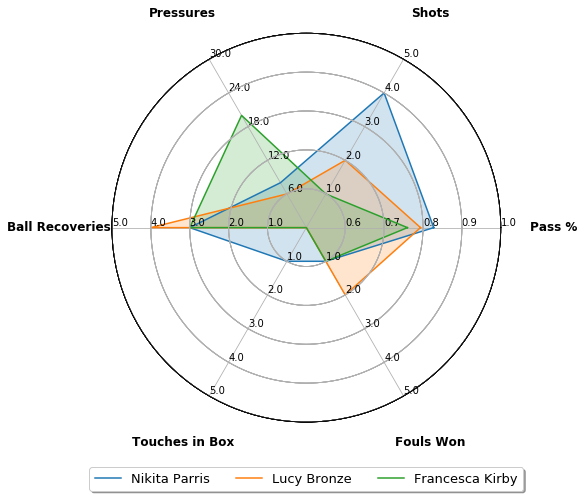

In [221]:
player_names = ['Nikita Parris', 'Lucy Bronze', 'Francesca Kirby']

ranges = [(0.5, 1.0), (0, 5), (0, 30),
         (0, 5), (0, 5), (0, 5)]     

variables = ['Pass %', 'Shots', 'Pressures', 'Ball Recoveries', 'Touches in Box', 'Fouls Won']

       
# plotting
fig1 = plt.figure(figsize=(6, 6))
radar2 = ComplexRadar(fig1, variables, ranges)

for player_name in player_names:
    data = list(get_player_stats(player_name).values())
    radar2.plot(data, label=player_name)
    radar2.fill(data, alpha=0.2)
    
radar2.ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),
      fancybox=True, shadow=True, ncol=4, fontsize=13)
plt.show()